In [2]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import clip
import torch
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

In [3]:
# 检查设备
device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载 CLIP 模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
# 数据路径
train_csv_path = 'PV train.csv'
train_img_dir = 'plantvillage/'
test_csv_path = 'PV test seen.csv'
test_img_dir = 'plantvillage/'

# 加载数据
train_df = pd.read_csv(train_csv_path, delimiter=',', header=None, names=['image', 'ignore', 'label'])
test_df = pd.read_csv(test_csv_path, delimiter=',', header=None, names=['image', 'ignore', 'label'])

train_df = train_df[['image', 'label']]
test_df = test_df[['image', 'label']]

train_df['image'] = train_df['image'].apply(lambda x: os.path.join(train_img_dir, x))
test_df['image'] = test_df['image'].apply(lambda x: os.path.join(test_img_dir, x))

train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)


plant_disease_descriptions = {
    0: "Healthy Leaf",
    1: "Apple Leaf with Scab",
    2: "Black Rot",
    3: "Cedar apple rust",
    4: "Powdery Mildew",
    5: "Cercospora leaf spot (Gray leaf spot)",
    6: "Common rust",
    7: "Northern Leaf Blight",
    8: "Esca (Black Measles)",
    9: "Leaf blight (Isariopsis Leaf Spot)",
    10: "Huanglongbing (Citrus Greening)",
    11: "Bacterial spot",
    12: "Early blight",
    13: "Late blight",
    14: "Leaf scorch",
    15: "Leaf Mold",
    16: "Septoria leaf spot",
    17: "Spider mites (Two-spotted spider mite)",
    18: "Target Spot",
    19: "Tomato Leaf with Yellow Leaf Curl Virus",
    20: "Tomato Leaf with Mosaic Virus",
}

In [5]:
# 合并所有文字描述
text_descriptions = list(plant_disease_descriptions.values())

# 提取文本特征
text_tokens = clip.tokenize(text_descriptions).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # 归一化文本特征

# Data augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),  # Resize to match CLIP's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
])

# Preprocess image with optional augmentation
def preprocess_image_with_augmentation(image_path, augment=False):
    image = Image.open(image_path).convert("RGB")
    if augment:
        image = augmentation_transforms(image)
    else:
        image = preprocess(image)  # Use CLIP's default preprocess pipeline
    return image.unsqueeze(0).to(device)

# Extract CLIP features with augmentation
def extract_clip_features_with_augmentation(df, clip_model, augment=False):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting CLIP Features"):
        image_path = row['image']
        label = row['label']
        image = preprocess_image_with_augmentation(image_path, augment=augment)
        with torch.no_grad():
            feature = clip_model.encode_image(image)
            feature /= feature.norm(dim=-1, keepdim=True)  # Normalize image features
        features.append(feature.cpu().numpy())
        labels.append(label)
    return tf.convert_to_tensor(features), tf.convert_to_tensor(labels)

In [6]:
# Extract augmented features for training set
train_features_augmented, train_labels_augmented = extract_clip_features_with_augmentation(
    train_df, clip_model, augment=True
)

# Extract normal features for test set (no augmentation for test)
test_features, test_labels = extract_clip_features_with_augmentation(test_df, clip_model, augment=False)

Extracting CLIP Features: 100%|██████████| 10279/10279 [02:04<00:00, 82.43it/s]


In [7]:
# 方案 1: 零样本分类
def classify_with_clip(image_path, clip_model, text_features):
    image = preprocess_image_with_augmentation(image_path)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # 归一化
        similarities = (image_features @ text_features.T).cpu().numpy()
        best_match_idx = similarities.argmax()
    return best_match_idx

# 示例: 零样本分类
example_image_path = train_df.iloc[0]['image']
predicted_label_idx = classify_with_clip(example_image_path, clip_model, text_features)
print(f"Predicted: {text_descriptions[predicted_label_idx]}")

# 方案 2: 联合特征训练分类器
# 转换为 TensorFlow 张量
train_features_augmented = tf.squeeze(train_features_augmented, axis=1)
test_features = tf.squeeze(test_features, axis=1)

Predicted: Tomato Leaf with Yellow Leaf Curl Virus


In [52]:
# 分类器
input_shape = train_features_augmented.shape[1:]
inputs = tf.keras.Input(shape=input_shape)
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Fixed: Updated to chain properly with previous layer
x = Dropout(0.3)(x)
outputs = Dense(len(set(train_labels_augmented.numpy())), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# 编译和训练
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
history = model.fit(train_features_augmented, train_labels_augmented, epochs=10, validation_data=(test_features, test_labels))


Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1452 - loss: 2.9689 - val_accuracy: 0.2736 - val_loss: 2.5683
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2304 - loss: 2.5841 - val_accuracy: 0.3290 - val_loss: 2.2873
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3487 - loss: 2.3280 - val_accuracy: 0.4726 - val_loss: 2.0066
Epoch 4/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4219 - loss: 2.0765 - val_accuracy: 0.5046 - val_loss: 1.7709
Epoch 5/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4705 - loss: 1.8702 - val_accuracy: 0.5385 - val_loss: 1.5957
Epoch 6/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5119 - loss: 1.7187 - val_accuracy: 0.5816 - val_loss: 1.4590
Epoch 7/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5446 - loss: 1.6002 - val_accuracy: 0.6185 - val_loss: 1.3487
Epoch 8/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5784 - loss: 1.4867 - 

In [54]:

# 测试
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


  1/322 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.0000 - loss: 0.0943

322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8357 - loss: 0.7228
Test Loss: 1.101216435432434, Test Accuracy: 0.7063916921615601


In [18]:
# 定义路径
unseen_test_csv_path = 'PV test unseen.csv'
unseen_test_img_dir = 'plantvillage/'

# 加载未见测试集
unseen_test_df = pd.read_csv(unseen_test_csv_path, delimiter=',', header=None, names=['image', 'ignore', 'label'])
unseen_test_df = unseen_test_df[['image', 'label']]

# 添加完整的图像路径
unseen_test_df['image'] = unseen_test_df['image'].apply(lambda x: os.path.join(unseen_test_img_dir, x))
unseen_test_df['label'] = unseen_test_df['label'].astype(int)

print(unseen_test_df.head())


                                               image  label
0  plantvillage/6820b823-5ed9-422d-ba0c-5134cd046...     11
1  plantvillage/821fa2f8-b221-472d-a789-f0c42923f...     11
2  plantvillage/70985466-254f-479b-86f2-9792be086...     11
3  plantvillage/b98b517c-c70a-4299-ba3d-857cd61ec...     11
4  plantvillage/41f3e9be-44a8-42b1-9654-8e7127bfc...     11


In [38]:
# 提取未见测试集的 CLIP 特征
unseen_test_features, unseen_test_labels = extract_clip_features_with_augmentation(unseen_test_df, clip_model)

Extracting CLIP Features: 100%|██████████| 216/216 [00:03<00:00, 62.62it/s]


In [39]:
# 移除多余的维度
unseen_test_features = tf.squeeze(unseen_test_features, axis=1)

In [57]:
# 评估模型在未见测试集上的性能
unseen_test_loss, unseen_test_accuracy = model.evaluate(unseen_test_features, unseen_test_labels)

print(f"Unseen Test Loss: {unseen_test_loss}")
print(f"Unseen Test Accuracy: {unseen_test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6290 - loss: 1.8162 
Unseen Test Loss: 1.7884529829025269
Unseen Test Accuracy: 0.625


In [58]:
model.save('VisualLanguageClipDisease.h5')

In [59]:
import numpy as np

def calculate_top_n_accuracy(model, features, labels, n=5):
    # 获取模型的预测结果
    predictions = model.predict(features)  # 输出为概率分布
    
    # 取前 N 个最高概率的索引
    top_n_predictions = np.argsort(predictions, axis=-1)[:, -n:]  # 倒序取前 N 个

    # 计算 Top-N 准确率
    correct = 0
    for i, label in enumerate(labels):
        if label in top_n_predictions[i]:
            correct += 1

    top_n_accuracy = correct / len(labels)
    return top_n_accuracy

# 计算 Top-1 和 Top-5 准确率
top_1_accuracy = calculate_top_n_accuracy(model, unseen_test_features, unseen_test_labels, n=1)
top_5_accuracy = calculate_top_n_accuracy(model, unseen_test_features, unseen_test_labels, n=5)

print(f"Top-1 Accuracy: {top_1_accuracy}")
print(f"Top-5 Accuracy: {top_5_accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Top-1 Accuracy: 0.625
Top-5 Accuracy: 0.9537037037037037


In [60]:
def calculate_harmonic_mean(seen_accuracy, unseen_accuracy):
    if seen_accuracy + unseen_accuracy == 0:
        return 0
    return 2 * (seen_accuracy * unseen_accuracy) / (seen_accuracy + unseen_accuracy)

# 假设 `seen_accuracy` 和 `unseen_accuracy` 是模型在已知和未知类别测试集上的准确率
seen_accuracy = model.evaluate(test_features, test_labels)[1]  # 测试集上的准确率
unseen_accuracy = unseen_test_accuracy  # 未见测试集上的准确率

harmonic_mean = calculate_harmonic_mean(seen_accuracy, unseen_accuracy)
print(f"Harmonic Mean: {harmonic_mean}")


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.8359 - loss: 0.7226
Harmonic Mean: 0.6632079953633977


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


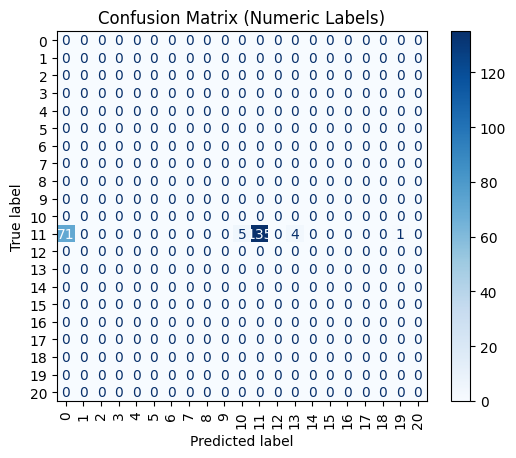

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 获取模型预测结果
predicted_probs = model.predict(unseen_test_features)  # 预测类别概率
predicted_labels = np.argmax(predicted_probs, axis=1)  # 获取每个样本的预测类别
true_labels = unseen_test_labels.numpy()  # 将 Tensor 转换为 NumPy

# 确保混淆矩阵的维度一致
num_classes = len(text_descriptions)  # 21 classes
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

# 显示
plt.title("Confusion Matrix (Numeric Labels)")
plt.show()


In [6]:
from tensorflow.keras.models import load_model

# Load the trained classification model
model_path = "VisualLanguageClipDisease.h5"  # Path to your saved model
classification_model = load_model(model_path)

# Test a single image
def test_single_image(image_path, clip_model, classification_model):
    # Preprocess the image and extract CLIP features
    image = preprocess_image_with_augmentation(image_path)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

    # Convert to TensorFlow tensor (remove extra dimension)
    image_features_tf = tf.convert_to_tensor(image_features.cpu().numpy())
    image_features_tf = tf.squeeze(image_features_tf, axis=0)

    # Predict using the loaded classification model
    predictions = classification_model.predict(tf.expand_dims(image_features_tf, axis=0))
    predicted_class = tf.argmax(predictions[0]).numpy()

    # Output the results
    predicted_label = plant_disease_descriptions[predicted_class]
    print(f"Predicted Class Index: {predicted_class}")
    print(f"Predicted Label: {predicted_label}")
    return predicted_class, predicted_label

# Example: Test a single image
test_image_path = "plantvillage/4b22a1e7-745b-4c78-a49e-14ca8cfba26a___RS_HL-8111.JPG"  # Replace with the path to your test image
predicted_class, predicted_label = test_single_image(
    test_image_path, clip_model, classification_model
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Class Index: 0
Predicted Label: Healthy Leaf
